In [671]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [928]:
import sys
from pathlib import Path
import json
import random
import re
import uuid
import shutil
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [747]:
project_path = '/datadisk2/qfeng/TextRecognitionDataGenerator'
data_path = Path('/datadisk4/tyin/gpt2/wiki_zh')
outp_path = Path('/datadisk2/qfeng/ocr_synthesis')

In [674]:
if project_path not in sys.path:
    sys.path.append(project_path)

In [675]:
%cd $project_path
%pwd

/datadisk2/qfeng/TextRecognitionDataGenerator


'/datadisk2/qfeng/TextRecognitionDataGenerator'

In [676]:
from trdg.generators import CompoundGenerator
from collections import namedtuple

In [677]:
conf = namedtuple('Conf', ['width', 'background_type', 'fit', 'line_margin', 'skewing_angle', 'random_skew', 'box_skewing_angle', 'box_random_skew', 'size'])
conf.size = 96
conf.background_type = 1
conf.fit = True
conf.line_margin = 5
conf.skewing_angle = 0
conf.random_skew = True
conf.box_skewing_angle = 3
conf.box_random_skew = True

In [678]:
generator = CompoundGenerator(background_type=conf.background_type, fit=conf.fit, line_margin=conf.line_margin, skewing_angle=conf.skewing_angle, random_skew=conf.random_skew, box_skewing_angle= conf.box_skewing_angle, box_random_skew=conf.box_random_skew, size=conf.size)

In [696]:
long_letters_pattern = re.compile(r'[a-zA-Z]{3,}')
unchinese_pattern = re.compile(r'[^\u4e00-\u9fa5\s\w]')
html_pattern = re.compile(
    r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
)
other_url_pattern = re.compile(r'\/\/.*|[A-Za-z]:\\.*|[A-Za-z]:\/.*')

def find_chinese(inp):
    outp = re.sub(long_letters_pattern, '', inp)
    outp = re.sub(unchinese_pattern, '', outp)
    return outp


def cut_html_tags(inp):
    return re.sub(html_pattern, '', inp)


def cut_other_url_tags(inp):
    return re.sub(other_url_pattern, '', inp)


def cut_url_tags(inp):
    outp = cut_html_tags(inp)
    outp = cut_other_url_tags(outp)
    return outp

def cut_text(inp):
    return find_chinese(cut_url_tags(inp))

In [718]:
texts = []

In [719]:
special_symbol = ['&', '：', '[', ']', '、', '（', '）', ':']

In [720]:
def make_texts(inp):
    outp = []
    buf = []
    for i in inp:
        buf.append(i)
        
        if random.randint(0, 5) == 0:
            buf.append(special_symbol[random.randint(0, len(special_symbol)-1)])
        
        if random.randint(0, 10) == 0:
            outp.append(''.join(buf[:16]))
            buf = []
            
    return outp

In [721]:
def load_data():
    for d in data_path.glob('*/*'):
        with open(str(d), 'r') as f:
            for line in f.readlines():
                data = json.loads(line.strip('\n'))
                for t in data['text'].split('\n'):
                    t = cut_text(t)
                    if len(t.strip(' ')) > 0:
                        texts.extend(make_texts(t))                        

In [746]:
# load_data()
# len(texts)

In [748]:
texts = []

with open(str(outp_path/'input_texts.txt')) as f:
    for line in f.readlines():
        texts.append(line.strip('\n'))

In [749]:
len(texts)

28094837

In [897]:
def gen_image(inp_texts):    
    args = namedtuple('Args', ['font', 'texts', 'bold', 'box_margins', 'box_lines', 'alignment'])
    n_texts = random.randint(1, 5)
    args.texts = [inp_texts[random.randint(0, len(inp_texts))] for _ in range(n_texts)]   
    args.font = '/datadisk2/qfeng/TextRecognitionDataGenerator/trdg/fonts/cn/SimSun.ttf'
    args.bold = False
    args.box_margins = (random.randint(16, 256), random.randint(16, 256))
    args.box_lines = (random.randint(0, 1), random.randint(0, 1), random.randint(0, 1), random.randint(0, 1))
    args.alignment = random.randint(0, 1)
    img, img_locs = generator.gen(args)
    return img, img_locs, args.texts

[(239.4609165794742, 210.72422195466282), (381.3744140161859, 215.67995048641797), (378.0240623327458, 311.62146988025114), (236.1105648960341, 306.665741348496)]
[(236.1105648960341, 306.665741348496), (598.889435103966, 319.3342586515039), (595.5390834205259, 415.2757780453371), (232.760213212594, 402.60726074232923)]


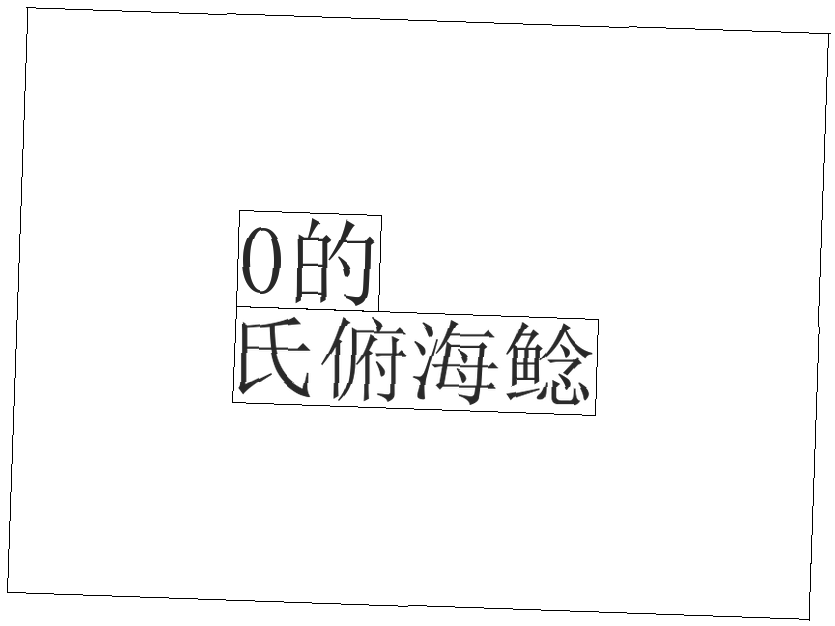

In [917]:
img, img_locs, c = gen_image(texts)
img

In [943]:
def save_generated(tag, inp_texts, size, font):
    gt_dname = outp_path/(tag + '_gt')
    img_dname = outp_path/(tag + '_img')
   
    if gt_dname.exists():
        shutil.rmtree(str(gt_dname))
    gt_dname.mkdir()
        
    if img_dname.exists():
        shutil.rmtree(str(img_dname))
    img_dname.mkdir()
    
    for _ in range(size):
        img, img_locs, contents = gen_image(inp_texts)
        name = str(uuid.uuid4())
        img.save(str((img_dname/(name + '.png'))))
        
        with open(str(gt_dname/(name + '.txt')), 'w') as f:            
            for c, loc in zip(contents, img_locs):
                line = []
                for i_ in loc:
                    line.append(str(round(i_[0], 2)))
                    line.append(str(round(i_[1], 2)))
                line.append('"' + c + '"')
                line.append(font)
                f.write(','.join(line) + '\n')

In [959]:
def parallel_save(tag, inp, n_splits, bs, font, n_workers):
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        func = partial(save_generated, size=bs, font=font)
        step = len(inp)//n_splits
        splits = list(range(0, len(inp), step))
        for i in range(1, len(splits)):
            print(splits[i-1], splits[i])
            ex.submit(func, tag + '_' + str(i), inp[splits[i-1]:splits[i]])

In [ ]:
parallel_save(tag='texts', inp=texts, n_splits=100, bs=50000, font='SimSun', n_workers=40)

0 280948
280948 561896
561896 842844
842844 1123792
1123792 1404740
1404740 1685688
1685688 1966636
1966636 2247584
2247584 2528532
2528532 2809480
2809480 3090428
3090428 3371376
3371376 3652324
3652324 3933272
3933272 4214220
4214220 4495168
4495168 4776116
4776116 5057064
5057064 5338012
5338012 5618960
5618960 5899908
5899908 6180856
6180856 6461804
6461804 6742752
6742752 7023700
7023700 7304648
7304648 7585596
7585596 7866544
7866544 8147492
8147492 8428440
8428440 8709388
8709388 8990336
8990336 9271284
9271284 9552232
9552232 9833180
9833180 10114128
10114128 10395076
10395076 10676024
10676024 10956972
10956972 11237920
11237920 11518868
11518868 11799816
11799816 12080764
12080764 12361712
12361712 12642660
12642660 12923608
12923608 13204556
13204556 13485504
13485504 13766452
13766452 14047400
14047400 14328348
14328348 14609296
14609296 14890244
14890244 15171192
15171192 15452140
15452140 15733088
15733088 16014036
16014036 16294984
16294984 16575932
16575932 16856880
168

In [724]:
with open('/datadisk2/qfeng/ocr_synthesis/input_texts.txt', 'w') as f:
    for t in texts:
        f.write(t + '\n')

In [767]:
digit_texts = []

for _ in range(100000):
    buf = []
    n_digits = random.randint(5, 16)
    
    for _ in range(n_digits):
        buf.append(str(random.randint(0, 9)))
        digit_texts.append(''.join(buf))    

In [ ]:
save_generated('digit', digit_texts, 100000)

In [772]:
small_letter_texts = []

for _ in range(100000):
    buf = []
    n_digits = random.randint(5, 16)
    
    for _ in range(n_digits):
        buf.append(chr(random.randint(65, 90)))
        small_letter_texts.append(''.join(buf))    

In [ ]:
save_generated('small_letter', small_letter_texts, 100000)

In [774]:
big_letter_texts = []

for _ in range(100000):
    buf = []
    n_digits = random.randint(5, 16)
    
    for _ in range(n_digits):
        buf.append(chr(random.randint(97, 122)))
        big_letter_texts.append(''.join(buf))   

In [ ]:
save_generated('big_letter', big_letter_texts, 100000)

In [777]:
letter_texts = []

for _ in range(100000):
    buf = []
    n_digits = random.randint(5, 16)
    
    for _ in range(n_digits):
        if random.randint(0, 10) == 0:
            buf.append('-')
        elif random.randint(0,1) == 0:        
            buf.append(chr(random.randint(65, 90)))
        else:
            buf.append(chr(random.randint(97, 122)))
        letter_texts.append(''.join(buf))   

In [ ]:
save_generated('letter', letter_texts, 100000)